# **Graph Workflows**

## **What's Covered?**
1. Sequential Graph
2. Conditional Graph
3. Conditional Looping Graph

## **Conditional Graph**

In [6]:
# Step 1: Defining a State
from typing import TypedDict, List

# Define a typed state
class AgentState(TypedDict):
    name: str
    values: List[int]
    operation: str
    response: str

In [16]:
# Step 2: Defining graph nodes
from functools import reduce

def greet_node(state: AgentState) -> AgentState:
    """This function greets the user."""
    state['response'] = f"Hi {state['name']}"
    return state

def sum_node(state: AgentState) -> AgentState:
    """This function takes a list and return the sum of all the values."""
    state['response'] = state['response'] + f"Sum of input list is {sum(state['values'])}."
    return state

def prod_node(state: AgentState) -> AgentState:
    """This function takes a list and return the product of all the values."""
    state['response'] = state['response'] + f"Product of input list is {reduce(lambda x,y : x*y, state['values'])}."
    return state

def decision_node(state: AgentState) -> AgentState:
    "This function decides the next node in the graph"
    if state['operation'] == "+":
        return "addition_operation"
    elif state['operation'] == "*":
        return "product_operation"

In [17]:
# Step 3: Define a Graph

from langgraph.graph import StateGraph, START, END

graph = StateGraph(AgentState)

graph.add_node("greeter", greet_node)
graph.add_node("add", sum_node)
graph.add_node("product", prod_node)
graph.add_node("router", lambda state:state) # Passthrough

graph.add_edge(START, "greeter")
graph.add_edge("greeter", "router")
graph.add_conditional_edges(
    "router",
    decision_node,
    {
        "addition_operation": "add",
        "product_operation": "product"
    }
)
graph.add_edge("add", END)
graph.add_edge("product", END)

In [19]:
# Step 4: Compile the graph

app = graph.compile()

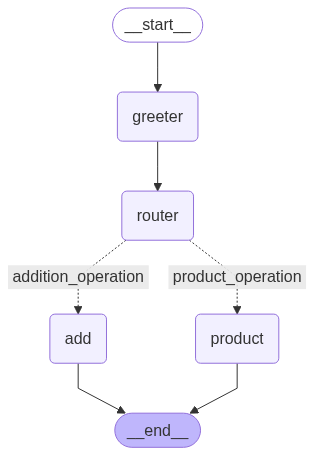

In [20]:
# Visualize the Graph

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
app.invoke({"name": "ThatAIGuy", "values": [5, -1, 0, 2, 9], "operation": "*"})

{'name': 'ThatAIGuy',
 'values': [5, -1, 0, 2, 9],
 'operation': '*',
 'response': 'Hi ThatAIGuyProduct of input list is 0.'}

In [22]:
app.invoke({"name": "ThatAIGuy", "values": [5, -1, 0, 2, 9], "operation": "+"})

{'name': 'ThatAIGuy',
 'values': [5, -1, 0, 2, 9],
 'operation': '+',
 'response': 'Hi ThatAIGuySum of input list is 15.'}